# Autoencoders for non-supervised intrusion detection

We train the autoencoders with 'normal' traffic <br>
Then detects abnormal traffic <br>
\
\

In [1]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from tensorflow import keras
from sklearn.preprocessing import normalize
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # to avoid warning messages = 3 

2022-03-04 17:28:16.606082: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-04 17:28:16.606104: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
def label_marker(row):
    if isinstance(row['marker'], str) and 'Natural' in row['marker']:
        return 0
    if isinstance(row['marker'], str) and 'Attack' in row['marker']:
        return 1
    return 


In [3]:
path = './data/Zero_Day/'
path_normal = path +'Normal.csv'
path_combine = path +'Combine.csv'
path_attack = path +'Attack.csv'

traffic_df = pd.read_csv(path_normal)  
combine_df = pd.read_csv(path_combine)  
attack_df = pd.read_csv(path_attack)  

combine_df['marker'] = combine_df.apply(label_marker, axis=1)
combine_labels = combine_df['marker'].to_numpy() 
len(combine_labels)

78377

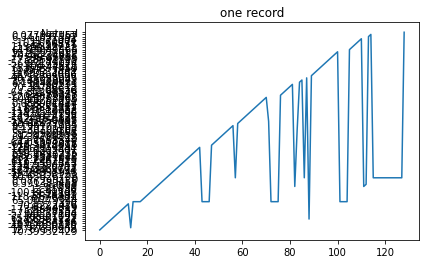

In [4]:
y = traffic_df.iloc[[0]].values.tolist() 
x = list(range(0, len(y[0])))
fig = plt.figure()
plt.plot(x,y[0])
plt.title('one record')
plt.show()

In [5]:
traffic_df.columns

Index(['R1-PA1:VH', 'R1-PM1:V', 'R1-PA2:VH', 'R1-PM2:V', 'R1-PA3:VH',
       'R1-PM3:V', 'R1-PA4:IH', 'R1-PM4:I', 'R1-PA5:IH', 'R1-PM5:I',
       ...
       'control_panel_log4', 'relay1_log', 'relay2_log', 'relay3_log',
       'relay4_log', 'snort_log1', 'snort_log2', 'snort_log3', 'snort_log4',
       'marker'],
      dtype='object', length=129)

In [6]:
# Delete marker column in dataframe as it is not numeric < check with darshana >
traffic_df.drop(['marker'], axis=1, inplace=True)
combine_df.drop(['marker'], axis=1, inplace=True)
attack_df.drop(['marker'], axis=1, inplace=True)

In [7]:
# each row of the dataframe is considered a sequence
# we create a numpy array with the sequences
traffic_np = traffic_df.to_numpy()
print('normal shape',traffic_np.shape)
combine_np = combine_df.to_numpy()
print('combine shape', combine_np.shape)
attack_np = attack_df.to_numpy()
print('attack shape', attack_np.shape)

normal shape (22714, 128)
combine shape (78377, 128)
attack shape (55663, 128)


In [8]:
# This is how it looks
traffic_np
print(traffic_np.shape)

(22714, 128)


In [9]:
# manage NaNs & inf
print('normal traffic NaNs', np.count_nonzero(np.isnan(traffic_np)))
print('normal traffic inf', np.count_nonzero(np.isinf(traffic_np)))
print('combine traffic NaNs', np.count_nonzero(np.isnan(combine_np)))
print('combine traffic inf', np.count_nonzero(np.isinf(combine_np)))
print('attack traffic NaNs', np.count_nonzero(np.isnan(attack_np)))
print('attack traffic inf', np.count_nonzero(np.isinf(attack_np)))
traffic_np = np.nan_to_num(traffic_np, copy=False, nan=0.0, posinf=0.0, neginf=0.0)
combine_np = np.nan_to_num(combine_np, copy=False, nan=0.0, posinf=0.0, neginf=0.0)
attack_np = np.nan_to_num(attack_np, copy=False, nan=0.0, posinf=0.0, neginf=0.0)
# not so sure that inf is correctly set to 0

normal traffic NaNs 0
normal traffic inf 3753
combine traffic NaNs 0
combine traffic inf 10906
attack traffic NaNs 0
attack traffic inf 7153


In [10]:
# normalize the data on each column
# Normalize and save the mean and std we get,
# for normalizing test data.

traffic_np_norm = normalize(traffic_np, axis=0, norm='max')
combine_np_norm = normalize(combine_np, axis=0, norm='max')
attack_np_norm = normalize(attack_np, axis=0, norm='max')

In [11]:
x_train = traffic_np_norm[...,np.newaxis]
x_combine = combine_np_norm[...,np.newaxis]
x_attack = attack_np_norm[...,np.newaxis]
print("Normal Traffic Training input shape: ", x_train.shape)
print("Combine Traffic Test input shape: ", x_combine.shape)
print("Attack Traffic Test input shape: ", x_attack.shape)

Normal Traffic Training input shape:  (22714, 128, 1)
Combine Traffic Test input shape:  (78377, 128, 1)
Attack Traffic Test input shape:  (55663, 128, 1)


In [12]:
def build_model():
    input_a = layers.Input(shape=(x_train.shape[1], x_train.shape[2]))
    x = layers.Conv1D(filters=128, kernel_size=7, padding="same", strides=2, activation="relu")(input_a)
    x = layers.Dropout(rate=0.2)(x)
    x = layers.Conv1D(filters=64, kernel_size=7, padding="same", strides=2, activation="relu")(x)
    x = layers.Dropout(rate=0.2)(x)
    x = layers.Conv1D(filters=32, kernel_size=7, padding="same", strides=2, activation="relu")(x)
    x = layers.Dropout(rate=0.2)(x)
    x = layers.Conv1D(filters=16, kernel_size=7, padding="same", strides=2, activation="relu")(x)
    x = layers.Conv1DTranspose(filters=16, kernel_size=7, padding="same", strides=2, activation="relu")(x)
    x = layers.Dropout(rate=0.2)(x)
    x = layers.Conv1DTranspose(filters=32, kernel_size=7, padding="same", strides=2, activation="relu")(x)
    x = layers.Dropout(rate=0.2)(x)
    x = layers.Conv1DTranspose(filters=64, kernel_size=7, padding="same", strides=2, activation="relu")(x)
    x = layers.Dropout(rate=0.2)(x)
    x = layers.Conv1DTranspose(filters=128, kernel_size=7, padding="same", strides=2, activation="relu")(x)
    output = layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same")(x)
    
    model = keras.Model(inputs=[input_a], outputs=output)
    
    return model

keras.backend.clear_session()

model = build_model()
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 64, 128)           1024      
                                                                 
 dropout (Dropout)           (None, 64, 128)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 32, 64)            57408     
                                                                 
 dropout_1 (Dropout)         (None, 32, 64)            0         
                                                                 
 conv1d_2 (Conv1D)           (None, 16, 32)            14368     
                                                                 
 dropout_2 (Dropout)         (None, 16, 32)            0     

2022-03-04 17:28:22.482755: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-04 17:28:22.483154: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-04 17:28:22.483232: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-03-04 17:28:22.483303: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-03-04 17:28:22.485351: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

In [13]:
## Train the model

#Note that we are using `x_train` as both the input and the target
#since this is a reconstruction model.
#"""

history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/50
160/160 [==============================] - 9s 51ms/step - loss: 0.0967 - val_loss: 0.0268
Epoch 2/50
160/160 [==============================] - 8s 50ms/step - loss: 0.0349 - val_loss: 0.0172
Epoch 3/50
160/160 [==============================] - 8s 50ms/step - loss: 0.0242 - val_loss: 0.0122
Epoch 4/50
160/160 [==============================] - 8s 52ms/step - loss: 0.0193 - val_loss: 0.0096
Epoch 5/50
160/160 [==============================] - 10s 60ms/step - loss: 0.0169 - val_loss: 0.0083
Epoch 6/50
160/160 [==============================] - 10s 61ms/step - loss: 0.0152 - val_loss: 0.0072
Epoch 7/50
160/160 [==============================] - 9s 58ms/step - loss: 0.0141 - val_loss: 0.0066
Epoch 8/50
160/160 [==============================] - 9s 56ms/step - loss: 0.0132 - val_loss: 0.0065
Epoch 9/50
160/160 [==============================] - 9s 55ms/step - loss: 0.0126 - val_loss: 0.0060
Epoch 10/50
160/160 [==============================] - 9s 56ms/step - loss: 0.0120 - val_

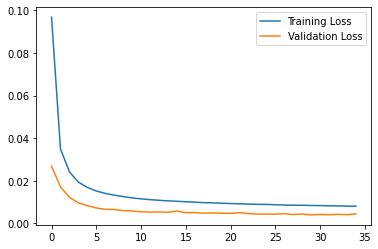

In [14]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

In [28]:
### Test the results
## use combine_labels as ground truth

# Get test attack loss.
x_attack_pred = model.predict(x_attack)
attack_mae_loss = np.mean(np.abs(x_attack_pred - x_attack), axis=1)
attack_mae_loss = attack_mae_loss.reshape((-1))

# Get test MAE loss.
x_test_pred = model.predict(x_combine)
test_mae_loss = np.mean(np.abs(x_test_pred - x_combine), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

# Get train MAE loss.
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)
train_mae_loss = train_mae_loss.reshape((-1))
threshold_calc = np.max(train_mae_loss)
print('calculated threshold',threshold_calc)

threshold = 0.02476

# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))


calculated threshold 0.2475733551650615
Number of anomaly samples:  78376
Indices of anomaly samples:  (array([    0,     1,     2, ..., 78374, 78375, 78376]),)


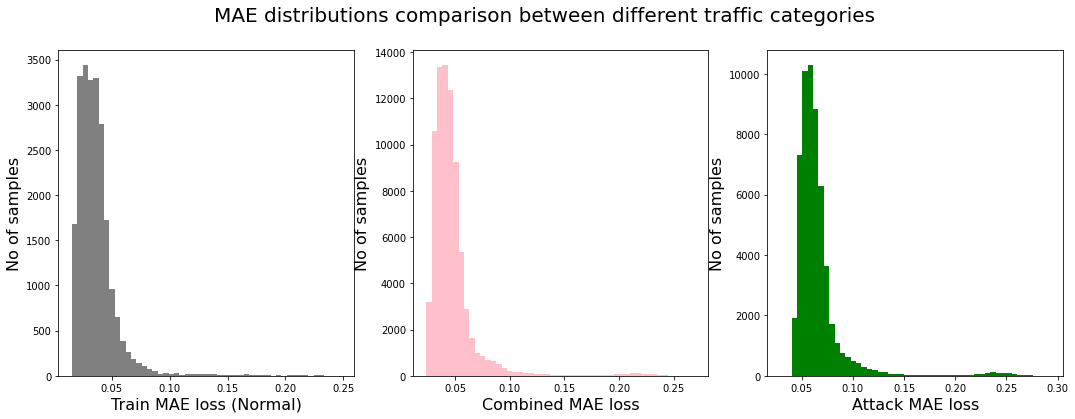

In [29]:
# comparison of MAE distributions (attack, normal and combined)
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(18,6))
fig.suptitle('MAE distributions comparison between different traffic categories',size=20)
ax1.hist(train_mae_loss, bins=50, color='grey')
ax1.set_xlabel('Train MAE loss (Normal)', size=16)
ax1.set_ylabel('No of samples', size = 16)
ax2.hist(test_mae_loss, bins=50, color='pink')
ax2.set_xlabel('Combined MAE loss', size = 16)
ax2.set_ylabel('No of samples', size = 16)
ax3.hist(attack_mae_loss, bins=50, color='green')
ax3.set_xlabel('Attack MAE loss', size = 16)
ax3.set_ylabel('No of samples', size = 16)
plt.show()

In [30]:
print("number of attacks", np.sum(combine_labels), 'number of normal ', 
      len(combine_labels) - np.sum(combine_labels))

number of attacks 55663 number of normal  22714


In [31]:
def accuracy_labels(a,b):
    i=0
    n = 0
    p = 0
    fp = 0
    fn = 0
    ac = 0
    for i in range (0,len(a)):
        if (a[i] == False) and(b[i] == 0): # False and 0 is normal traffic right
            n = n + 1
            ac = ac + 1
        elif (a[i] == True) and (b[i]==1): # True (attack) and 1 attack is attack right
            p = p + 1
            ac = ac + 1
        elif (a[i] == False) and (b[i] == 1): # False (normal) and 1 is false negative
            fn = fn + 1
        elif (a[i] == True) and (b[i] == 0): # True (attack) and 0 is false positive
            fp = fp + 1
        else:
            print (a[i], b[i])
    print (i, '-> elements')
    return n, p, fp, fn, ac
            

In [32]:
neg, pos, false_pos, false_neg, accuracy = accuracy_labels(anomalies, combine_labels)

78376 -> elements


In [33]:
print ('accuracy :', accuracy/len(combine_labels))
print ('negatives :', neg)
print ('positives :', pos)
print ('false negatives :', false_neg)
print ('false positives :', false_pos)

accuracy : 0.7101828342498437
negatives : 0
positives : 55662
false negatives : 1
false positives : 22714


In [21]:
#EOF